<a href="https://colab.research.google.com/github/Habonit/sparta_coding_ai/blob/main/week3_advanced_translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -qU kagglehub kaggle transformers datasets evaluate sacrebleu torchinfo

# Week3 심화 과제: 기계 번역

1) 영어 -> 프랑스어 번역 과제

2) 사용 모델: t5(인코더 - 디코더 구조의 모델)

3) 다음 코드 참조: https://huggingface.co/docs/transformers/ko/tasks/translation

4) t5를 통하여 영어 -> 프랑스어 번역 모델을 만들고 훈련 전후의 metric 비교를 수행할 것입니다. 이 때 코드의 간소화를 위해 huggingface trainer를 사용하였습니다.

## 1 [My Code] Preparation

In [ ]:
import torch
import kagglehub
from pathlib import Path
import pandas as pd

# 데이터셋은 캐글 데이터의 영어 <-> 프랑스어 번역 데이터였습니다.
path = kagglehub.dataset_download("devicharith/language-translation-englishfrench")
print("Path to dataset files:", path)

# 추후 훈련 데이터를 간단히 build 하기 위하여 칼럼명을 en과 fr로 미리 바꿔 놓았습니다.
dir_path = Path(path)
train_path = dir_path / "eng_-french.csv"
train_df = pd.read_csv(train_path)
train_df.columns = ['en','fr']
# # 예시로 1000개만 사용할 거면 아래 코드 주석을 풀고 실행하면 됩니다.
# train_df = train_df.iloc[range(1000)]

# 모델 config입니다.
model_name = "google-t5/t5-base"
random_state = 42
batch_size = 64
max_len = 128
results_dir = './results/week3_advanced'
lr = 2e-5
n_epochs = 30

Path to dataset files: /root/.cache/kagglehub/datasets/devicharith/language-translation-englishfrench/versions/2


In [ ]:
from transformers import AutoModelForSeq2SeqLM
from transformers import AutoTokenizer, DataCollatorForSeq2Seq
from pprint import pprint

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
# 모델 출력의 토큰수를 임의로 지정할 수 있습니다.
# 만약 더 길게 원하면 늘릴 수 있습니다.
model.config.max_length = 32

# 아래는 모델 config에 대한 전체 출력값입니다.
# 앞으로 finetuning을 할 때엔, 아래 config를 참고하여 classifer 등을 추가해야 합니다.
# finetuning 과정의 하이퍼파라미터는 pretraining 에서의 hyperparameter를 그대로 사용하는 것을 제1 원칙으로 합니다.
pprint(model.config)

T5Config {
  "_attn_implementation_autoset": true,
  "_name_or_path": "google-t5/t5-base",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "classifier_dropout": 0.0,
  "d_ff": 3072,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "max_length": 32,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
      "num_beams": 4,
      "prefix": "summarize: "
    },
    "translation_e

### 1.1 [My Code] Tokenizer와 Model 확인

1) 토크나이저

2) 모델: t5

In [ ]:
# 사전 확인
word2idx = {name: id for name, id in sorted(tokenizer.vocab.items(), key=lambda x: x[1])}
print(f"Vocab len: {tokenizer.vocab_size}")
print(list(word2idx.items())[:10])

Vocab len: 32100
[('<pad>', 0), ('</s>', 1), ('<unk>', 2), ('▁', 3), ('X', 4), ('.', 5), (',', 6), ('s', 7), ('▁the', 8), ('a', 9)]


In [ ]:
from torchinfo import summary
import torch

# 모델 구조도 확인
# 인코더-디코더 구조의 사전임을 확인할 수 있다.
encoder_input_ids = torch.randint(0, tokenizer.vocab_size, (batch_size, max_len), dtype=torch.int64).to(model.device) # Move to the same device as the model
decoder_input_ids = torch.randint(0, tokenizer.vocab_size, (batch_size, max_len), dtype=torch.int64).to(model.device) # Move to the same device as the model

# Print the model summary
print(summary(model, input_data={'input_ids': encoder_input_ids, 'decoder_input_ids': decoder_input_ids}))

Layer (type:depth-idx)                                  Output Shape              Param #
T5ForConditionalGeneration                              [64, 128, 768]            --
├─T5Stack: 1-1                                          [64, 128, 768]            109,628,544
├─T5Stack: 1-2                                          --                        (recursive)
│    └─Embedding: 2-1                                   [64, 128, 768]            24,674,304
├─T5Stack: 1-3                                          --                        (recursive)
│    └─Dropout: 2-2                                     [64, 128, 768]            --
│    └─ModuleList: 2-3                                  --                        --
│    │    └─T5Block: 3-1                                [64, 128, 768]            7,079,808
│    │    └─T5Block: 3-2                                [64, 128, 768]            7,079,424
│    │    └─T5Block: 3-3                                [64, 128, 768]            7,079,424
│   

In [ ]:
# 디코더의 3개 층만 학습하기 위하여 나머지는 동결시킵니다.
def extract_layer(layer):
    flag = False
    for name in ["decoder.block.11", "decoder.block.10", "decoder.block.9", "decoder.final_layer_norm.weight"]:
        if name in layer:
            flag = True
            break
    return flag

for name, param in model.named_parameters():
    param.requires_grad = False

# Decoder만 학습할 수 있게 함
for name, param in model.named_parameters():
    if extract_layer(name):
        param.requires_grad = True

In [ ]:
from torchinfo import summary
import torch
# 학습 가능한 파라미터 수가 3천만 개 정도로 확 줄었음을 확인할 수 있습니다.
encoder_input_ids = torch.randint(0, tokenizer.vocab_size, (batch_size, max_len), dtype=torch.int64).to(model.device) # Move to the same device as the model
decoder_input_ids = torch.randint(0, tokenizer.vocab_size, (batch_size, max_len), dtype=torch.int64).to(model.device) # Move to the same device as the model
print(summary(model, input_data={'input_ids': encoder_input_ids, 'decoder_input_ids': decoder_input_ids}))

Layer (type:depth-idx)                                  Output Shape              Param #
T5ForConditionalGeneration                              [64, 128, 768]            --
├─T5Stack: 1-1                                          [64, 128, 768]            109,628,544
├─T5Stack: 1-2                                          --                        (recursive)
│    └─Embedding: 2-1                                   [64, 128, 768]            (24,674,304)
├─T5Stack: 1-3                                          --                        (recursive)
│    └─Dropout: 2-2                                     [64, 128, 768]            --
│    └─ModuleList: 2-3                                  --                        --
│    │    └─T5Block: 3-1                                [64, 128, 768]            (7,079,808)
│    │    └─T5Block: 3-2                                [64, 128, 768]            (7,079,424)
│    │    └─T5Block: 3-3                                [64, 128, 768]            (7,079,4

### 1.2 [My Code] EDA (1)- Text Length

1) 길이 통계량 확인

    1) 길이 평균: 35 전후(표준편차: 15 전후)

    2) 길이 왜도: 1.5 전후

    3) 길이 첨도: 7 전후

2) 전체적으로 right-skewed 되어 있지만, 그 정도가 심하진 않습니다. 일부 긴 텍스트를 포함한 데이터가 포함되어 있지만, max_len = 128 정도만 줘도 99% 이상의 데이터가 제대로 학습이 될 것입니다.

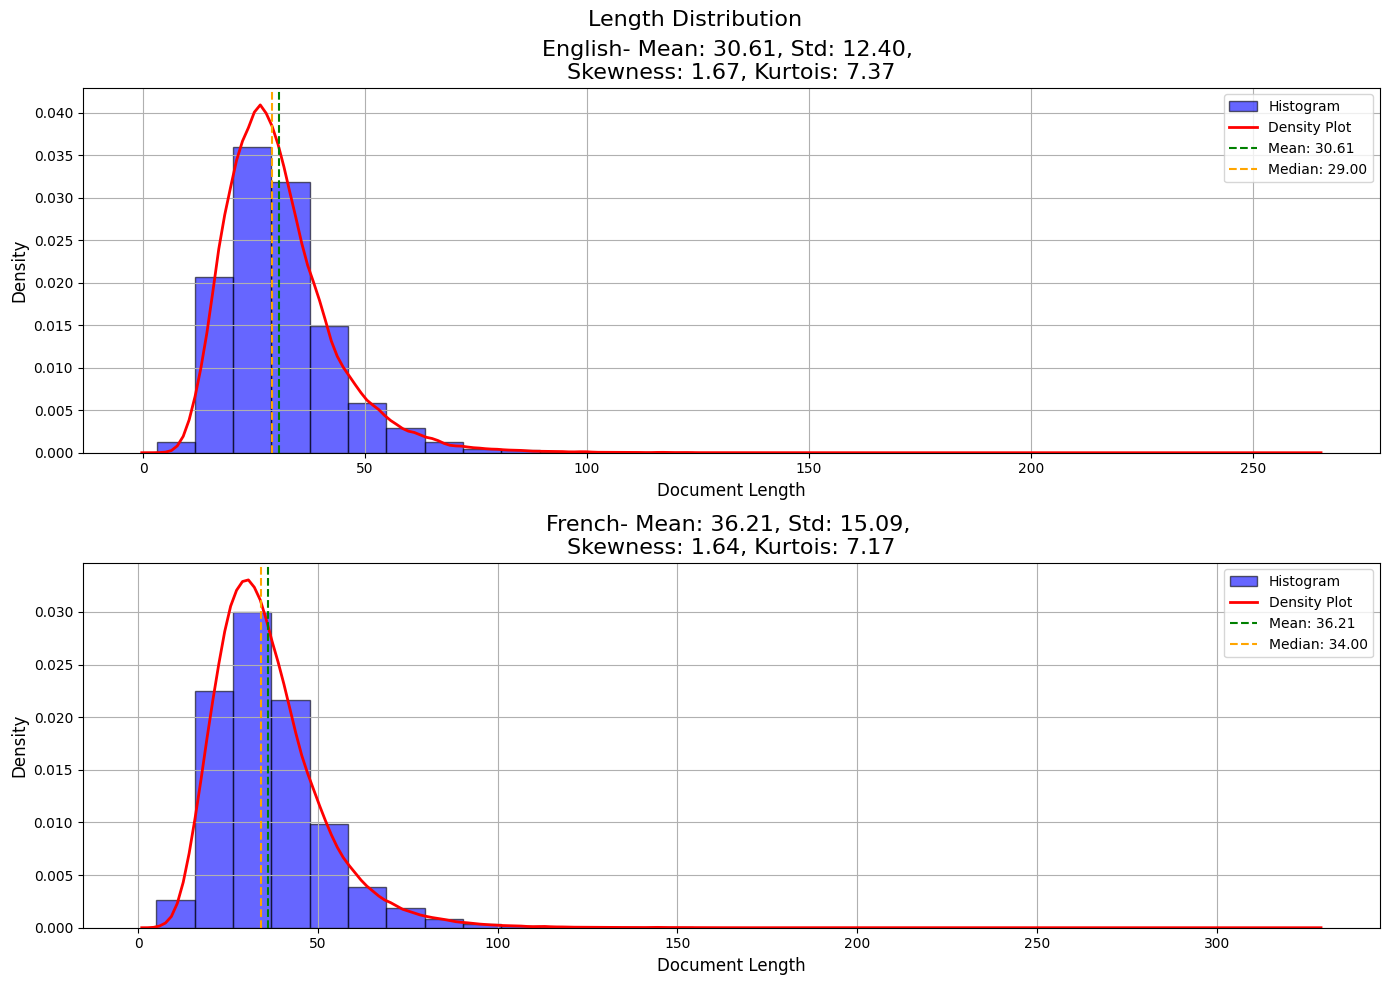

In [ ]:
# 평균, 표준편차, 왜도, 첨도 계산
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import skew, kurtosis

def length_plot(data, name):
    plt.hist(data, bins=30, alpha=0.6, label=f'Histogram', color='blue', edgecolor='black', density=True)
    sns.kdeplot(data, label=f'Density Plot', color='red', linewidth=2)

    mean_value = np.mean(data)
    mean_value = np.mean(data)
    std_dev = np.std(data)
    skewness = skew(data)
    kurt = kurtosis(data)
    median_value = np.median(data)

    plt.axvline(mean_value, color='green', linestyle='--', linewidth=1.5, label=f'Mean: {mean_value:.2f}')
    plt.axvline(median_value, color='orange', linestyle='--', linewidth=1.5, label=f'Median: {median_value:.2f}')
    plt.title(f'{name}- Mean: {mean_value:.2f}, Std: {std_dev:.2f}, \nSkewness: {skewness:.2f}, Kurtois: {kurt:.2f}', fontsize=16)
    plt.xlabel('Document Length', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend()
    plt.grid(True)

plt.figure(figsize=(14,10))

plt.subplot(2,1,1)
length_plot([len(data)for data in train_df['en']], 'English')

plt.subplot(2,1,2)
length_plot([len(data)for data in train_df['fr']], 'French')

plt.suptitle("Length Distribution", fontsize=16)
plt.tight_layout()
plt.show()


### 1.3 [My Code] Dataset Build

- 데이터셋을 다음과 같이 맞출 때 영어 프랑스어 번역 수행이 가능해집니다. 이는 모델 config에서 확인할 수 있습니다.

    1) prefix로 input 앞에 translate English to French: 토큰을 달아둡니다.

    2) 각각의 샘플을 input_ids와 attention_mask, labels로 tokenizing한다.

    3) input_ids와 labels는 en과 fr에 대한 정수 인코딩, attention_mask는 input_ids의 길이만큼 1이 부여된다.

- 데이터셋을 아래의 과정으로 전처리 해야 합니다

    1) en => input_ids와 attention_mask
    
    2)  fr => labels



In [ ]:
# prefix만 잘 달아주면 모델이 여러가지 작업을 수행할 수 있는 멀티 테스크 모델입니다.
# 이 중에서 우리는 translation_en_to_fr을 해야하기 때문에
# prefix로 translate English to French를 달아야 합니다.
model.config.task_specific_params

{'summarization': {'early_stopping': True,
  'length_penalty': 2.0,
  'max_length': 200,
  'min_length': 30,
  'no_repeat_ngram_size': 3,
  'num_beams': 4,
  'prefix': 'summarize: '},
 'translation_en_to_de': {'early_stopping': True,
  'max_length': 300,
  'num_beams': 4,
  'prefix': 'translate English to German: '},
 'translation_en_to_fr': {'early_stopping': True,
  'max_length': 300,
  'num_beams': 4,
  'prefix': 'translate English to French: '},
 'translation_en_to_ro': {'early_stopping': True,
  'max_length': 300,
  'num_beams': 4,
  'prefix': 'translate English to Romanian: '}}

In [ ]:
# 허깅페이스 데이터셋으로 만들기 위해 아래의 과정을 거칠 것입니다.
# 중간중간 print를 찍으며 shape을 확인하도록 합니다.
from datasets import Dataset, DatasetDict
index = []
texts = []
for i, row in train_df.iterrows():
    index.append(i)
    texts.append(row.to_dict())

train_data = {
    'id': index,
    "translation": texts,
}
train_dataset = Dataset.from_dict(train_data)

print(train_dataset)
print("\n"*2)
print(train_dataset['translation'][:2])

Dataset({
    features: ['id', 'translation'],
    num_rows: 175621
})



[{'en': 'Hi.', 'fr': 'Salut!'}, {'en': 'Run!', 'fr': 'Cours\u202f!'}]


In [ ]:
# 전처리 과정에서 중요한 것은 크게 두 가지 입니다
# tokenizer의 inputs으로 들어가기 위해선 모든 en text 앞에 prefix를 달아줘야 한다는 것입니다.
# tokenizer의 text_target은 fr이 그대로 들어가면 됩니다.
# 이 때 max_length가 128로 초기에 설정이 되어 있기 때문에 99% 이상의 데이터가 그대로 보존되면서 들어갑니다.
# 이를 넘어서는 길의의 텍스트는 truncate 됩니다.
from transformers import AutoTokenizer, DataCollatorForSeq2Seq
def preprocess_function(examples):
    inputs = [prefix + example[source_lang] for example in examples["translation"]]
    targets = [example[target_lang] for example in examples["translation"]]
    model_inputs = tokenizer(inputs, text_target=targets, max_length=max_len, truncation=True)
    # model_inputs = tokenizer(inputs, text_target=targets)
    return model_inputs


# 데이터 콜레이터의 역할은 모델이 batch 처리를 할 때 동적으로 max_len을 잡는 것입니다.
# 그럼으로써 훈련 시간을 효율적으로 줄이게 됩니다.
# 또한 special token이 무엇인지 인지하고 제일 마지막에 달아두는 등의 기능을 하기 때문에 tokenizer와 model을 넘겨줘야 합니다.
# 즉, batch 내의 가장 긴 문장을 기준으로 padding 처리를 하고 padding 값에 -100을 넣음으로써 추후에 softmax에 영향을 안 주도록 합니다
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    padding=True,
    )

source_lang = "en"
target_lang = "fr"
prefix = "translate English to French: "
tokenized_dataset = train_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/175621 [00:00<?, ? examples/s]

In [ ]:
# preprocess를 거친 데이터의 형태는 아래와 같습니다.
# preprocess 단계에서는 128이라는 max_len을 넘은 값만 잘리고 나머지는 그 길이를 유지합니다.
# 패딩 처리는 data_collator에서만 된다는 것이 핵심입니다.
from pprint import pprint

inputs = [prefix + x['en'] for i, x in enumerate(train_dataset['translation']) if i < 4]
targets = [x['fr'] for i, x in enumerate(train_dataset['translation']) if i < 4]
model_inputs = tokenizer(inputs, text_target=targets, max_length=max_len, truncation=True)
# model_inputs = tokenizer(inputs, text_target=targets)
print("Source 데이터 형태")
pprint(inputs)
print("\n"*2)
print("Target 데이터 형태")
pprint(targets)
print("\n"*2)
print("Model input 데이터 형태")
pprint(model_inputs)

Source 데이터 형태
['translate English to French: Hi.',
 'translate English to French: Run!',
 'translate English to French: Run!',
 'translate English to French: Who?']



Target 데이터 형태
['Salut!', 'Cours\u202f!', 'Courez\u202f!', 'Qui ?']



Model input 데이터 형태
{'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1],
                    [1, 1, 1, 1, 1, 1, 1, 1],
                    [1, 1, 1, 1, 1, 1, 1, 1],
                    [1, 1, 1, 1, 1, 1, 1, 1]],
 'input_ids': [[13959, 1566, 12, 2379, 10, 2018, 5, 1],
               [13959, 1566, 12, 2379, 10, 7113, 55, 1],
               [13959, 1566, 12, 2379, 10, 7113, 55, 1],
               [13959, 1566, 12, 2379, 10, 2645, 58, 1]],
 'labels': [[25801, 55, 1],
            [13579, 7, 3, 55, 1],
            [13579, 457, 3, 55, 1],
            [6590, 3, 58, 1]]}


In [ ]:
# 훈련: 70% / 검증: 20% / test : 10%입니다.
train_test_split = tokenized_dataset.train_test_split(test_size=0.3, seed=random_state)
train_dataset = train_test_split['train']
temp_dataset = train_test_split['test']

# 임시 데이터셋을 20% 검증용, 10% 테스트용으로 분할
val_test_split = temp_dataset.train_test_split(test_size=0.3333, seed=random_state)
val_dataset = val_test_split['train']
test_dataset = val_test_split['test']

dataset_dict = DatasetDict(
    {
        "train": train_dataset,
        "val": val_dataset,
        "test": test_dataset
    }
)

pprint(dataset_dict)

DatasetDict({
    train: Dataset({
        features: ['id', 'translation', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 122934
    })
    val: Dataset({
        features: ['id', 'translation', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 35126
    })
    test: Dataset({
        features: ['id', 'translation', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 17561
    })
})


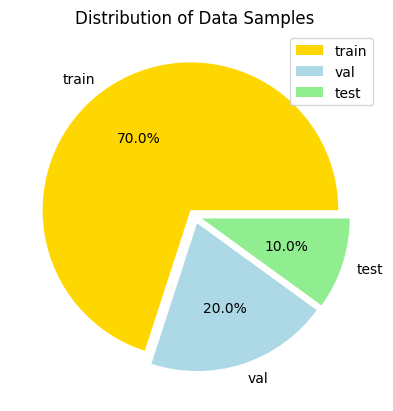

In [ ]:
import matplotlib.pyplot as plt

sizes = [len(train_dataset), len(val_dataset), len(test_dataset)]
labels = ['train', 'val', 'test']
colors = ['gold', 'lightblue', 'lightgreen']
explode = [0.05] * len(sizes)  # 각 조각을 0.1만큼 분리

plt.pie(sizes, labels=labels, colors=colors, explode=explode, autopct='%1.1f%%')
plt.title('Distribution of Data Samples')
plt.legend(loc='upper right')
plt.show()

### 1.4 [My Code] EDA (2)- Token Distribution

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
from transformers import AutoTokenizer

# 데이터셋 토큰화
input_tokens = []
label_tokens = []
for tokens in tokenized_dataset['input_ids']:
    input_tokens.extend(tokens)
for tokens in tokenized_dataset['labels']:
    label_tokens.extend(tokens)
nums = 50
input_token_counts = Counter(input_tokens)
label_token_counts = Counter(label_tokens)

top_10_input_tokens = input_token_counts.most_common(nums)
input_tokens, input_counts = zip(*top_10_input_tokens)

top_10_label_tokens = label_token_counts.most_common(nums)
label_tokens, label_counts = zip(*top_10_label_tokens)

<ipython-input-41-abcea6fb213d>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = [tokenizer.decode(name) for name in input_tokens], y=input_counts, palette="viridis")


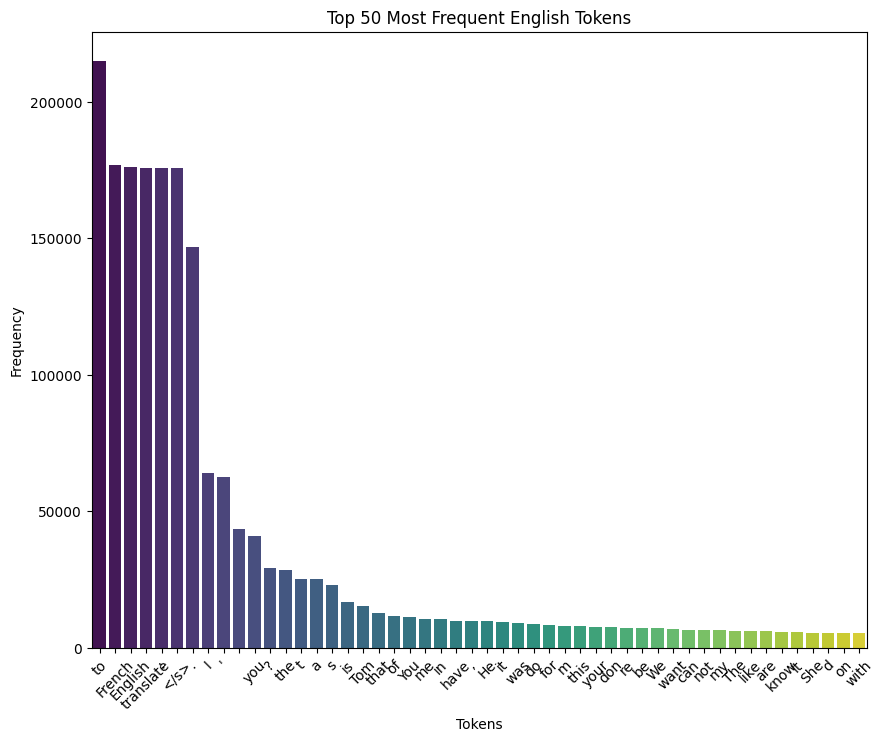

In [ ]:
import seaborn as sns
# 영어 단어 사용 빈도 바 차트입니다.
# 영어 토큰 중 prefix에 포함되는 단어가 확실히 많이 사용되는 것을 확인할 수 있습니다.
plt.figure(figsize=(10, 8))
sns.barplot(x = [tokenizer.decode(name) for name in input_tokens], y=input_counts, palette="viridis")
plt.xlabel("Tokens")
plt.ylabel("Frequency")
plt.title(f"Top {nums} Most Frequent English Tokens")
plt.xticks(rotation=45)
plt.show()

<ipython-input-42-9a7d9f80bef1>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[tokenizer.decode(name) for name in label_tokens], y=label_counts, palette="viridis")


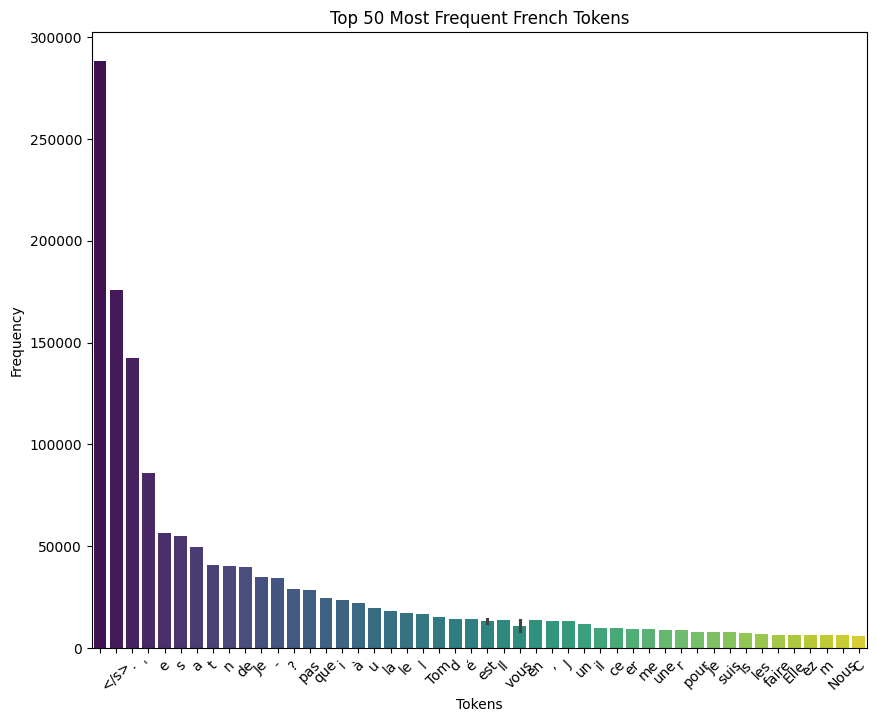

In [ ]:
# 프랑스어 사용 빈도 바 차트입니다.
plt.figure(figsize=(10, 8))
sns.barplot(x=[tokenizer.decode(name) for name in label_tokens], y=label_counts, palette="viridis")
plt.xlabel("Tokens")
plt.ylabel("Frequency")
plt.title(f"Top {nums} Most Frequent French Tokens")
plt.xticks(rotation=45)
plt.show()

## 2 [My Code] 훈련

### 2.1 [My Code] metric

1) bleu score를 사용합니다.

In [ ]:
import evaluate

metric_sacrebleu = evaluate.load("sacrebleu")

### 2.2 [My Code] metric 계산

1) compute metric은 huggingface trainer에서 핵심적인 함수이므로 반드시 공식문서를 확인하여 build합니다.

In [ ]:
# validation과 test 과정에서 metric을 찍기 위한 함수입니다.
# 특히 compute metrics는 갖춰야 하는 형태가 분명하기 때문에 항상 공식 문서를 참고해서 만들어야 합니다.
import numpy as np
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]
    return preds, labels


def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]

    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    # label 값이 -100이 아니라면, 그대로 labels를 사용하지만, 아니라면 pad 토큰인 0이 들어갑니다.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result_sacrebleu = metric_sacrebleu.compute(predictions=decoded_preds, references=decoded_labels)

    result = {
        'sacrebleu': result_sacrebleu['score']/100,
        }

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}
    return result

### 2.3 [My Code] 훈련 설정

In [ ]:
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer, logging

training_args = Seq2SeqTrainingArguments(
    output_dir=results_dir,
    eval_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01, # 가중치 감소율 (regularization)
    save_total_limit=3,
    num_train_epochs=n_epochs,
    predict_with_generate=True,# 번역 작업은 generate를 할 수 있어야 합니다.
    fp16=True, # 기본은 float64인데 이것을 최대한 줄여서 메모리를 효율적으로 사용합니다.
    report_to='none',
)

trainer = Seq2SeqTrainer(
    model=model,
    processing_class = tokenizer,
    args=training_args,
    train_dataset=dataset_dict["train"],
    eval_dataset=dataset_dict["val"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

### 2.4 [My Code] 훈련 이전의 metric

In [ ]:
from transformers import logging
# finetuning 이전의 모델을 가지로 metric을 찍어봅니다.
logging.set_verbosity_error()
def cal_metrics():
    test_results = trainer.predict(test_dataset=dataset_dict['test'])
    metrics = test_results.metrics
    print(metrics)
    return metrics

initial_metrics = cal_metrics()
display(pd.DataFrame([initial_metrics]))

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1527: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed in v5. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


{'test_loss': 0.70428067445755, 'test_model_preparation_time': 0.0065, 'test_sacrebleu': 0.4234, 'test_gen_len': 13.3201, 'test_runtime': 209.6892, 'test_samples_per_second': 83.748, 'test_steps_per_second': 1.311}


,test_loss,test_model_preparation_time,test_sacrebleu,test_gen_len,test_runtime,test_samples_per_second,test_steps_per_second
0,0.704281,0.0065,0.4234,13.3201,209.6892,83.748,1.311


### 2.5 [Log] 훈련 시작

In [ ]:
# naive pytorch로 훈련하는 것보다 코드가 훨씬 간단해지는 것을 확인할 수 있습니다.
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:2817: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 32}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


{'loss': 0.7204, 'grad_norm': 0.43736588954925537, 'learning_rate': 1.9333333333333333e-05, 'epoch': 1.0}
{'eval_loss': 0.5604720711708069, 'eval_model_preparation_time': 0.0065, 'eval_sacrebleu': 0.4538, 'eval_gen_len': 13.5338, 'eval_runtime': 417.4949, 'eval_samples_per_second': 84.135, 'eval_steps_per_second': 1.315, 'epoch': 1.0}
{'loss': 0.6654, 'grad_norm': 0.45295414328575134, 'learning_rate': 1.866666666666667e-05, 'epoch': 2.0}
{'eval_loss': 0.5349103212356567, 'eval_model_preparation_time': 0.0065, 'eval_sacrebleu': 0.4635, 'eval_gen_len': 13.5007, 'eval_runtime': 417.583, 'eval_samples_per_second': 84.117, 'eval_steps_per_second': 1.315, 'epoch': 2.0}
{'loss': 0.6408, 'grad_norm': 0.4988357126712799, 'learning_rate': 1.8e-05, 'epoch': 3.0}
{'eval_loss': 0.5196962952613831, 'eval_model_preparation_time': 0.0065, 'eval_sacrebleu': 0.4702, 'eval_gen_len': 13.4841, 'eval_runtime': 417.5139, 'eval_samples_per_second': 84.131, 'eval_steps_per_second': 1.315, 'epoch': 3.0}
{'loss'

TrainOutput(global_step=57630, training_loss=0.5609424438158837, metrics={'train_runtime': 17075.84, 'train_samples_per_second': 215.979, 'train_steps_per_second': 3.375, 'train_loss': 0.5609424438158837, 'epoch': 30.0})

### 2.6 [My Code] Fine tuning 이후의 metric

In [ ]:
# 해당 metric은 finetuning 이후의 metric입니다.
metrics = cal_metrics()
display(pd.DataFrame([metrics]))

{'test_loss': 0.447680801153183, 'test_model_preparation_time': 0.0065, 'test_sacrebleu': 0.4977, 'test_gen_len': 13.4484, 'test_runtime': 207.1938, 'test_samples_per_second': 84.756, 'test_steps_per_second': 1.327}


,test_loss,test_model_preparation_time,test_sacrebleu,test_gen_len,test_runtime,test_samples_per_second,test_steps_per_second
0,0.447681,0.0065,0.4977,13.4484,207.1938,84.756,1.327


## 3 [My Code] 결과 plotting

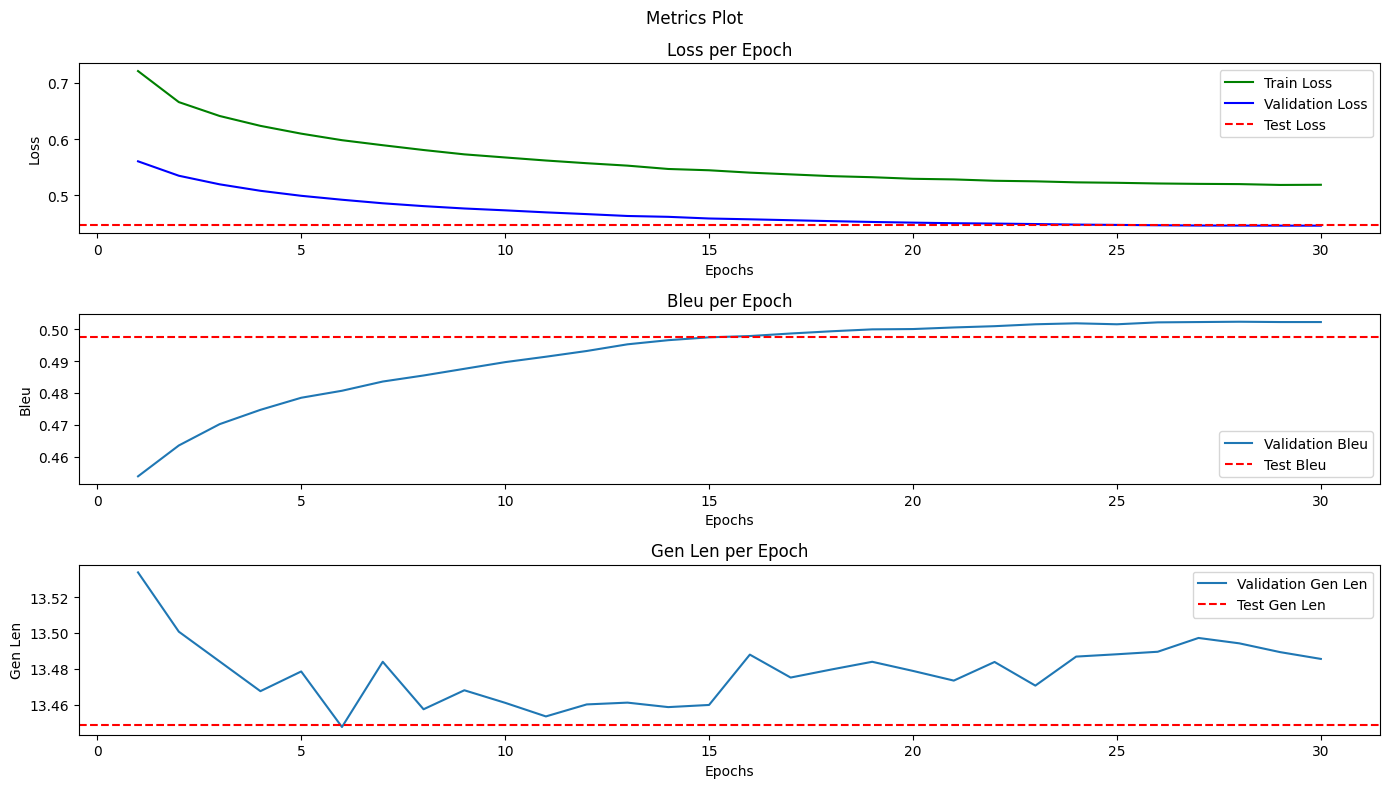

In [ ]:
import matplotlib.pyplot as plt

def plotting():
    # 로그 데이터 추출
    log_history = trainer.state.log_history

    # 메트릭 초기화
    epochs = []
    train_loss = []
    val_loss = []
    val_sacreblew = []
    val_gen_len = []

    # 로그 데이터 분리
    for log in log_history:
        if 'epoch' in log:
            current_epoch = log['epoch']
            if current_epoch not in epochs:
                epochs.append(current_epoch)
            if 'loss' in log:
                train_loss.append(log['loss'])
            if 'eval_loss' in log:
                val_loss.append(log['eval_loss'])
            if 'eval_sacrebleu' in log:
                val_sacreblew.append(log['eval_sacrebleu'])
            if 'eval_gen_len' in log:
                val_gen_len.append(log['eval_gen_len'])

    test_loss = metrics['test_loss']
    test_sacrebleu = metrics['test_sacrebleu']
    test_gen_len = metrics['test_gen_len']

    # 플로팅
    plt.figure(figsize=(14, 8))

    # 손실 플롯
    plt.subplot(3, 1, 1)
    plt.plot(epochs, train_loss, color = 'g', label='Train Loss')
    plt.plot(epochs, val_loss, color = 'b', label='Validation Loss')
    plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()


    plt.subplot(3, 1, 2)
    plt.plot(epochs, val_sacreblew, label='Validation Bleu')
    plt.axhline(y=test_sacrebleu, color='r', linestyle='--', label='Test Bleu')
    plt.xlabel('Epochs')
    plt.ylabel('Bleu')
    plt.title('Bleu per Epoch')
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.plot(epochs, val_gen_len, label='Validation Gen Len')
    plt.axhline(y=test_gen_len, color='r', linestyle='--', label='Test Gen Len')
    plt.xlabel('Epochs')
    plt.ylabel('Gen Len')
    plt.title('Gen Len per Epoch')
    plt.legend()

    plt.suptitle(f"Metrics Plot")
    plt.tight_layout()
    print("\n\n")

plotting()

## 4 [My Code] 모델 결과 차트화

In [ ]:
import pandas as pd
# initial metric과 훈련 이후의 metric을 비교합니다.

def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# 학습 가능한 파라미터 수 출력
trainable_params_lst = [count_trainable_parameters(model) ]
train_runtime_lst = [trainer.state.log_history[-1]['train_runtime']]

result_df = pd.DataFrame([metrics])
result_df.index = ["model"]
result_df['trainable_parameters']  = trainable_params_lst
result_df['train_runtime'] = train_runtime_lst
initial_row = pd.DataFrame([initial_metrics])[["test_loss",'test_sacrebleu','test_gen_len']]
initial_row.index = ["initial_model"]
result_df = pd.concat([result_df, initial_row], axis=0).fillna("")

display(result_df[['test_loss','test_sacrebleu','test_gen_len','trainable_parameters', 'train_runtime', 'test_runtime']])

,test_loss,test_sacrebleu,test_gen_len,trainable_parameters,train_runtime,test_runtime
model,0.447681,0.4977,13.4484,28319232.0,17075.84,207.1938
initial_model,0.704281,0.4234,13.3201,,,


## 5 [My Code] Conclusion

1) t5를 사용하여 초기 blew 0.42에서 0.50까지 성능을 향상시킨 것을 확인

2) 훈련 파라미터 수를 3천만 개 정도로 제한했는데, 이를 늘릴 경우 성능이 나아질 가능성이 있음.

3) 단 3천만개의 훈련 가능 파라미터를 30epoch 훈련하는데에도 5시간 정도 소요되어 더 이상의 실험은 현실적으로 어렵다고 판단.